# Caffe学习系列：初识数据可视化

首先将caffe的根目录作为当前目录，然后加载caffe程序自带的小猫图片并显示。

图片大小为$360 \times 480$，三通道：

(360, 480, 3)


(-0.5, 479.5, 359.5, -0.5)

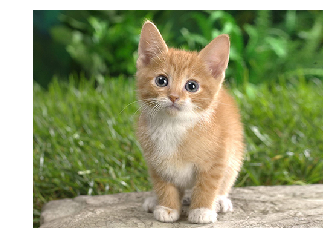

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import caffe
caffe_root='/root/Repository/caffe/'
import os, sys
os.chdir(caffe_root)
sys.path.insert(0, caffe_root+'python')
im = caffe.io.load_image('examples/images/cat.jpg')
print(im.shape)
plt.imshow(im)
plt.axis('off')

打开examples/net_surgery/conv.prototxt文件，修改两个地方：

一是将input_shape由原来的(1, 1, 100, 100)修改为(1, 3, 100, 100)，即由单通道灰度图变为三通道彩色图。

二是将过滤器个数(num_output)由3改为16，多增加一些filter，当然保持原来的数不变也行。

其他地方不变，修改后的prototxt如下，只有一个卷积层：

In [2]:
! cat examples/net_surgery/conv.prototxt

# Simple single-layer network to showcase editing model parameters.
name: "convolution"
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param { shape: { dim: 1 dim: 3 dim: 100 dim: 100 } }
}
layer {
  name: "conv"
  type: "Convolution"
  bottom: "data"
  top: "conv"
  convolution_param {
    num_output: 16
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}


将图片数据加载到blobs，但反过来，我们也可以从blobs中提取出原始数据，并进行显示。

显示的时候要注意各维的顺序，如blobs的顺序是(1, 3, 360, 480)，从前往后分别表示1张图片，3个通道，图片大小为$360 \times 480$，需要调用transpose改变为(360, 480, 3)才能正常显示。

其中用data\[0\]表示第一张图片，下标从0开始，此例只有一张图片，因此只能是data\[0\]。

分别用data\[0, 0\]，data\[0, 1\]和data\[0, 2\]表示该图片的三个通道。

('data-blobs', (1, 3, 360, 480))


(-0.5, 479.5, 359.5, -0.5)

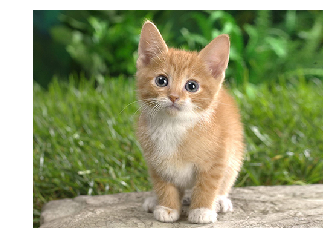

In [3]:
net = caffe.Net('examples/net_surgery/conv.prototxt', caffe.TEST)
im_input = im[np.newaxis, :, :, :].transpose(0, 3, 1, 2)
print("data-blobs", im_input.shape)
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
plt.imshow(net.blobs['data'].data[0].transpose(1, 2, 0))
plt.axis('off')

编写一个show_data函数来显示数据：

In [4]:
plt.rcParams['image.cmap'] = 'gray'

def show_data(data, head, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filter into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.title(head)
    plt.imshow(data)
    plt.axis('off')

从blobs数据中将原始图片提取出来，并分别显示不同的通道图：

('data-blobs: ', (1, 3, 360, 480))


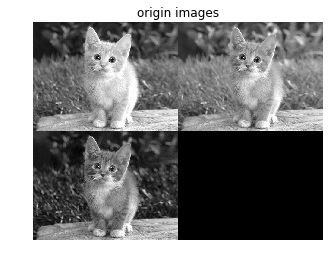

In [5]:
print("data-blobs: ", (net.blobs['data'].data.shape))
show_data(net.blobs['data'].data[0], 'origin images')

调用forward()执行卷积操作，blobs数据发生改变。由原来的(1, 3, 360, 480)变为(1, 16, 356, 476)。

并初始化生成了相应的权值，权值数据为(16, 3, 5, 5)。

最后调用两次show_data来分别显示权值和卷积过滤后的16通道图片。

('data-blobs: ', (1, 3, 360, 480))
('conv-blobs: ', (1, 16, 356, 476))
('weight-blobs: ', (16, 3, 5, 5))


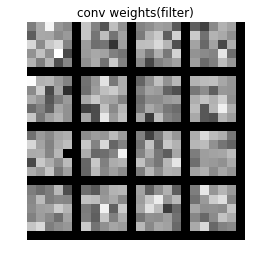

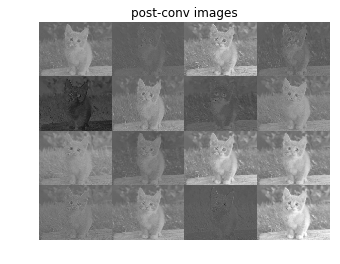

In [6]:
net.forward()
print("data-blobs: ", net.blobs['data'].data.shape)
print("conv-blobs: ", net.blobs['conv'].data.shape)
print("weight-blobs: ", net.params['conv'][0].data.shape)
show_data(net.params['conv'][0].data[:, 0], 'conv weights(filter)')
show_data(net.blobs['conv'].data[0], 'post-conv images')